In [1]:
#MAE271D Project
# MPC

from algames import ALGAMES
from mpc import MPC

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# M players
M = 3

# N horizon length
N = 10

# n state size
n = 4  # (x, y, v_x, v_y)

# m control input size
m = 2  # (a_x, a_y)

# timestep
dt = 0.1 

# collision avoidance radius
r = 0.1

# running cost matrix
Q = np.eye(n)

# terminal cost matrix
Qf = np.eye(n) * 100

# control cost matrix
R = np.eye(m)

# penalty gain
rho = 1

# penalty schedule
gamma = 10

# convergence tolerance
eps = 1e-6

# max iterations
max_iter = 20

# multiplier to enforce dynamics
dynamics_mult = 100

In [3]:
# initial state
x1_0 = np.array([1, 0, 1.5, 0])
x2_0 = np.array([0.1, 0, 1.5, 0])
x3_0 = np.array([0.3, 0.5, 2.5, 0])
list_x0 = [x1_0, x2_0, x3_0]

# final state
x1_f = np.array([3.8, 0, 1.5, 0])
x2_f = np.array([3.2, 0, 2, 0])
x3_f = np.array([3.5, 0, 2, 0])
list_xf = [x1_f, x2_f, x3_f]

# constraints
constraint_wall_y = 1
constraint_u_x_max = 10
constraint_u_y_max = constraint_u_x_max

In [4]:
X_mpc, U_mpc = MPC(
        M,  # number players
        N,  # horizon
        n,  # state size
        m,  # control input size
        dt,  # timestep
        r,  # collision avoidance radius
        list_x0,  # list of initial states
        list_xf,  # list of target states
        Q,  # running cost matrix
        Qf,  # terminal cost matrix
        R,  # control cost matrix
        rho,  # constraint penalty value
        gamma,  # constraint penalty schedule
        eps,  # convergence tolerance
        constraint_wall_y,  # y value of horizontal wall
        constraint_u_x_max,  # control input x bound
        constraint_u_y_max,  # control input y bound
        max_iter,
        dynamics_mult,
    )

0 y_max=7.373 rho=1 C_vio=-0.079
1 y_max=7.374 rho=10 C_vio=-0.079
2 y_max=7.374 rho=100 C_vio=-0.079
3 y_max=7.374 rho=1000 C_vio=-0.079
4 y_max=7.374 rho=10000 C_vio=-0.079
5 y_max=7.374 rho=100000 C_vio=-0.079
6 y_max=7.374 rho=1000000 C_vio=-0.079
7 y_max=7.374 rho=10000000 C_vio=-0.079
8 y_max=7.374 rho=100000000 C_vio=-0.079
9 y_max=7.374 rho=1000000000 C_vio=-0.079
10 y_max=7.374 rho=10000000000 C_vio=-0.079
11 y_max=7.374 rho=100000000000 C_vio=-0.079
12 y_max=7.374 rho=1000000000000 C_vio=-0.079
13 y_max=7.374 rho=10000000000000 C_vio=-0.079
14 y_max=7.374 rho=100000000000000 C_vio=-0.079
15 y_max=7.374 rho=1000000000000000 C_vio=-0.079
0 y_max=3.797 rho=1 C_vio=-0.079
1 y_max=3.797 rho=10 C_vio=-0.079
2 y_max=3.797 rho=100 C_vio=-0.079
3 y_max=3.797 rho=1000 C_vio=-0.079
4 y_max=3.797 rho=10000 C_vio=-0.079
5 y_max=3.797 rho=100000 C_vio=-0.079
6 y_max=3.797 rho=1000000 C_vio=-0.079
7 y_max=3.797 rho=10000000 C_vio=-0.079
8 y_max=3.797 rho=100000000 C_vio=-0.079
9 y_max=3.797

Text(0.5, 1.0, 'Position')

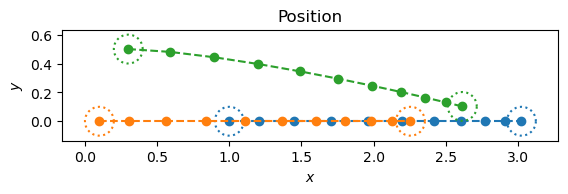

In [5]:
x_players = np.split(X_mpc, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

# plot
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    plt.plot(x[0, :], x[1, :], "o--")

    # plot cola radius
    plt.plot(x[0, 0] + c_cos, x[1, 0] + c_sin, ":", c=f"C{i}")
    plt.plot(x[0, -1] + c_cos, x[1, -1] + c_sin, ":", c=f"C{i}")
plt.gca().set_aspect("equal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")

Text(0.5, 0.98, 'Velocity')

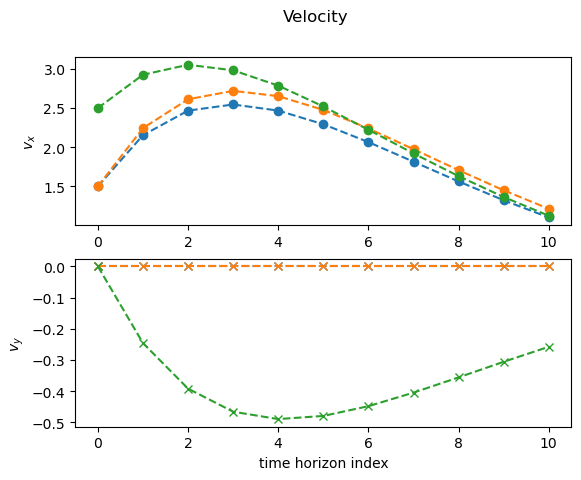

In [6]:
# velocity
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    ax = plt.subplot(211)
    ax.plot(x[2, :], "o--", c=f"C{i}")
    plt.ylabel('$v_x$')
    ax = plt.subplot(212)
    ax.plot(x[3, :], "x--", c=f"C{i}")
    plt.ylabel('$v_y$')
plt.xlabel('time horizon index')
plt.suptitle("Velocity")

Text(0.5, 0.98, 'Control input')

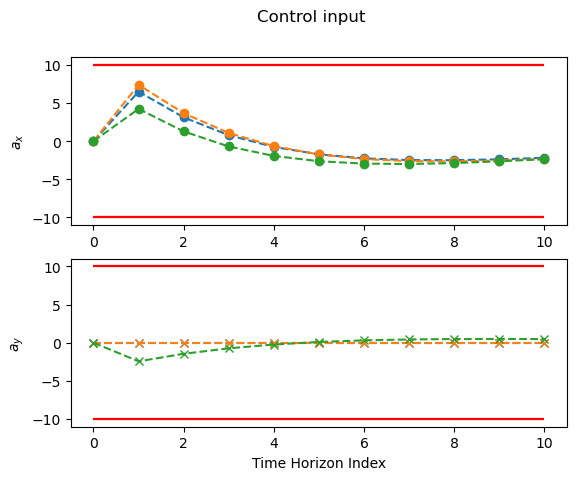

In [7]:
u_players = np.split(U_mpc, M)

# plot
plt.figure()
for i, u in enumerate(u_players):
    u = np.reshape(u, (m, N+1), order="F")
    ax = plt.subplot(211)
    plt.plot(u[0, :], "o--", c=f"C{i}")
    plt.hlines((constraint_u_x_max, -constraint_u_x_max), 0, N, "r")
    plt.ylabel('$a_x$')
    ax = plt.subplot(212)
    plt.plot(u[1, :], "x--", c=f"C{i}")
    plt.hlines((constraint_u_y_max, -constraint_u_y_max), 0, N, "r")
    plt.ylabel('$a_y$')
plt.xlabel('Time Horizon Index')
plt.suptitle("Control input")